<a href="https://colab.research.google.com/github/mostafa-ja/sample/blob/master/Building_a_Recurrent_Neural_Network_Step_by_Step_v3a_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building your Recurrent Neural Network - Step by Step

Welcome to Course 5's first assignment! In this assignment, you will implement key components of a Recurrent Neural Network in numpy.

Recurrent Neural Networks (RNN) are very effective for Natural Language Processing and other sequence tasks because they have "memory". They can read inputs $x^{\langle t \rangle}$ (such as words) one at a time, and remember some information/context through the hidden layer activations that get passed from one time-step to the next. This allows a unidirectional RNN to take information from the past to process later inputs. A bidirectional RNN can take context from both the past and the future. 

**Notation**:
- Superscript $[l]$ denotes an object associated with the $l^{th}$ layer. 

- Superscript $(i)$ denotes an object associated with the $i^{th}$ example. 

- Superscript $\langle t \rangle$ denotes an object at the $t^{th}$ time-step. 
    
- **Sub**script $i$ denotes the $i^{th}$ entry of a vector.

Example:  
- $a^{(2)[3]<4>}_5$ denotes the activation of the 2nd training example (2), 3rd layer [3], 4th time step <4>, and 5th entry in the vector.



Let's first import all the packages that you will need during this assignment.

In [1]:
!wget 'https://raw.githubusercontent.com/mostafa-ja/coursera-deep-learning-specialization/master/C5%20-%20Sequence%20Models/Week%201/Building%20a%20Recurrent%20Neural%20Network%20-%20Step%20by%20Step/rnn_utils.py'

--2022-09-01 14:24:27--  https://raw.githubusercontent.com/mostafa-ja/coursera-deep-learning-specialization/master/C5%20-%20Sequence%20Models/Week%201/Building%20a%20Recurrent%20Neural%20Network%20-%20Step%20by%20Step/rnn_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5155 (5.0K) [text/plain]
Saving to: ‘rnn_utils.py’

rnn_utils.py        100%[===================>]   5.03K  --.-KB/s    in 0s      

2022-09-01 14:24:27 (58.9 MB/s) - ‘rnn_utils.py’ saved [5155/5155]



In [2]:
import numpy as np
from rnn_utils import *

## 1 - Forward propagation for the basic Recurrent Neural Network

Later this week, you will generate music using an RNN. The basic RNN that you will implement has the structure below. In this example, $T_x = T_y$. 

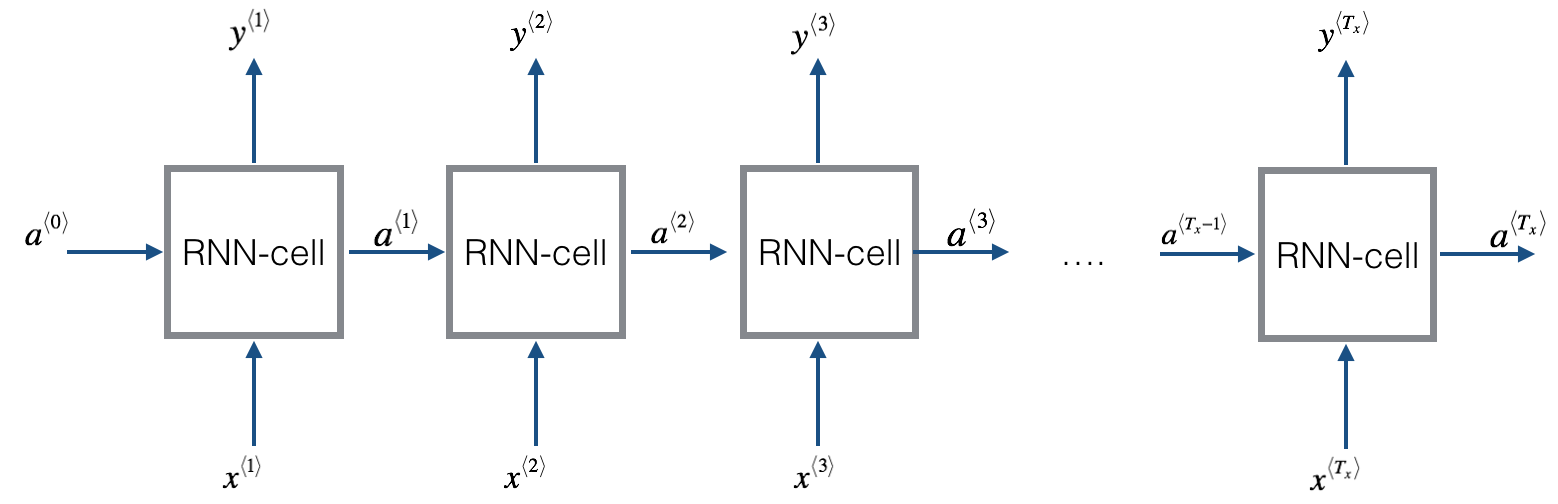

<caption><center> **Figure 1**: Basic RNN model </center></caption>

### Dimensions of input $x$

#### Input with $n_x$ number of units
* For a single input example, $x^{(i)}$ is a one-dimensional input vector.
* Using language as an example, a language with a 5000 word vocabulary could be one-hot encoded into a vector that has 5000 units.  So $x^{(i)}$ would have the shape (5000,).  
* We'll use the notation $n_x$ to denote the number of units in a single training example.

#### Batches of size $m$
* Let's say we have mini-batches, each with 20 training examples.  
* To benefit from vectorization, we'll stack 20 columns of $x^{(i)}$ examples into a 2D array (a matrix).
* For example, this tensor has the shape (5000,20). 
* We'll use $m$ to denote the number of training examples.  
* So the shape of a mini-batch is $(n_x,m)$

#### Time steps of size $T_{x}$
* A recurrent neural network has multiple time steps, which we'll index with $t$.
* In the lessons, we saw a single training example $x^{(i)}$ (a vector) pass through multiple time steps $T_x$.  For example, if there are 10 time steps, $T_{x} = 10$

#### 3D Tensor of shape $(n_{x},m,T_{x})$
* The 3-dimensional tensor $x$ of shape $(n_x,m,T_x)$ represents the input $x$ that is fed into the RNN.

#### Taking a 2D slice for each time step: $x^{\langle t \rangle}$
* At each time step, we'll use a mini-batches of training examples (not just a single example).
* So, for each time step $t$, we'll use a 2D slice of shape $(n_x,m)$.
* We're referring to this 2D slice as $x^{\langle t \rangle}$.  The variable name in the code is `xt`.

### Definition of hidden state $a$

* The activation $a^{\langle t \rangle}$ that is passed to the RNN from one time step to another is called a "hidden state."

### Dimensions of hidden state $a$

* Similar to the input tensor $x$, the hidden state for a single training example is a vector of length $n_{a}$.
* If we include a mini-batch of $m$ training examples, the shape of a mini-batch is $(n_{a},m)$.
* When we include the time step dimension, the shape of the hidden state is $(n_{a}, m, T_x)$
* We will loop through the time steps with index $t$, and work with a 2D slice of the 3D tensor.  
* We'll refer to this 2D slice as $a^{\langle t \rangle}$. 
* In the code, the variable names we use are either `a_prev` or `a_next`, depending on the function that's being implemented.
* The shape of this 2D slice is $(n_{a}, m)$

### Dimensions of prediction $\hat{y}$
* Similar to the inputs and hidden states, $\hat{y}$ is a 3D tensor of shape $(n_{y}, m, T_{y})$.
    * $n_{y}$: number of units in the vector representing the prediction.
    * $m$: number of examples in a mini-batch.
    * $T_{y}$: number of time steps in the prediction.
* For a single time step $t$, a 2D slice $\hat{y}^{\langle t \rangle}$ has shape $(n_{y}, m)$.
* In the code, the variable names are:
    - `y_pred`: $\hat{y}$ 
    - `yt_pred`: $\hat{y}^{\langle t \rangle}$

Here's how you can implement an RNN: 

**Steps**:
1. Implement the calculations needed for one time-step of the RNN.
2. Implement a loop over $T_x$ time-steps in order to process all the inputs, one at a time. 

## 1.1 - RNN cell

A recurrent neural network can be seen as the repeated use of a single cell. You are first going to implement the computations for a single time-step. The following figure describes the operations for a single time-step of an RNN cell. 

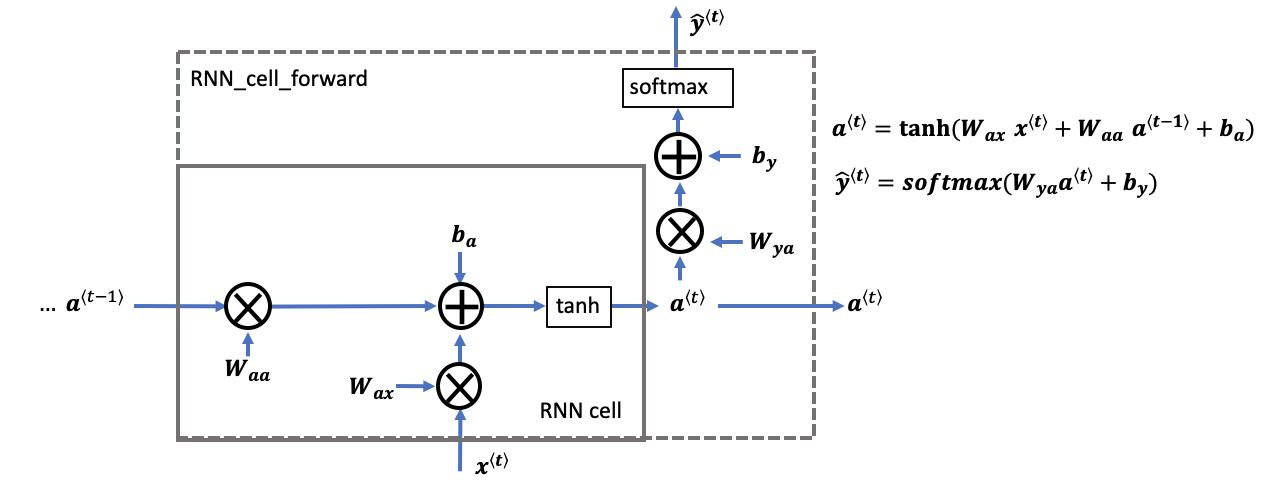
<caption><center> **Figure 2**: Basic RNN cell. Takes as input $x^{\langle t \rangle}$ (current input) and $a^{\langle t - 1\rangle}$ (previous hidden state containing information from the past), and outputs $a^{\langle t \rangle}$ which is given to the next RNN cell and also used to predict $\hat{y}^{\langle t \rangle}$ </center></caption>

#### rnn cell versus rnn_cell_forward
* Note that an RNN cell outputs the hidden state $a^{\langle t \rangle}$.  
    * The rnn cell is shown in the figure as the inner box which has solid lines.  
* The function that we will implement, `rnn_cell_forward`, also calculates the prediction $\hat{y}^{\langle t \rangle}$
    * The rnn_cell_forward is shown in the figure as the outer box that has dashed lines.

**Exercise**: Implement the RNN-cell described in Figure (2).

**Instructions**:
1. Compute the hidden state with tanh activation: $a^{\langle t \rangle} = \tanh(W_{aa} a^{\langle t-1 \rangle} + W_{ax} x^{\langle t \rangle} + b_a)$.
2. Using your new hidden state $a^{\langle t \rangle}$, compute the prediction $\hat{y}^{\langle t \rangle} = softmax(W_{ya} a^{\langle t \rangle} + b_y)$. We provided the function `softmax`.
3. Store $(a^{\langle t \rangle}, a^{\langle t-1 \rangle}, x^{\langle t \rangle}, parameters)$ in a `cache`.
4. Return $a^{\langle t \rangle}$ , $\hat{y}^{\langle t \rangle}$ and `cache`

#### Additional Hints
* [numpy.tanh](https://www.google.com/search?q=numpy+tanh&rlz=1C5CHFA_enUS854US855&oq=numpy+tanh&aqs=chrome..69i57j0l5.1340j0j7&sourceid=chrome&ie=UTF-8)
* We've created a `softmax` function that you can use.  It is located in the file 'rnn_utils.py' and has been imported.
* For matrix multiplication, use [numpy.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html)



In [3]:
# GRADED FUNCTION: rnn_cell_forward

def rnn_cell_forward(xt, a_prev, parameters):
    """
    Implements a single forward step of the RNN-cell as described in Figure (2)

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, a_prev, xt, parameters)
    """
    
    # Retrieve parameters from "parameters"
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]
    
    ### START CODE HERE ### (≈2 lines)
    # compute next activation state using the formula given above
    a_next = np.tanh(np.dot(Waa,a_prev) + np.dot(Wax,xt) + ba)
    # compute output of the current cell using the formula given above
    yt_pred = softmax(np.dot(Wya,a_next) + by)   
    ### END CODE HERE ###
    
    # store values you need for backward propagation in cache
    cache = (a_next, a_prev, xt, parameters)
    
    return a_next, yt_pred, cache

In [4]:
np.random.seed(1)
xt_tmp = np.random.randn(3,10)
a_prev_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Waa'] = np.random.randn(5,5)
parameters_tmp['Wax'] = np.random.randn(5,3)
parameters_tmp['Wya'] = np.random.randn(2,5)
parameters_tmp['ba'] = np.random.randn(5,1)
parameters_tmp['by'] = np.random.randn(2,1)

a_next_tmp, yt_pred_tmp, cache_tmp = rnn_cell_forward(xt_tmp, a_prev_tmp, parameters_tmp)
print("a_next[4] = \n", a_next_tmp[4])
print("a_next.shape = \n", a_next_tmp.shape)
print("yt_pred[1] =\n", yt_pred_tmp[1])
print("yt_pred.shape = \n", yt_pred_tmp.shape)

a_next[4] = 
 [ 0.59584544  0.18141802  0.61311866  0.99808218  0.85016201  0.99980978
 -0.18887155  0.99815551  0.6531151   0.82872037]
a_next.shape = 
 (5, 10)
yt_pred[1] =
 [0.9888161  0.01682021 0.21140899 0.36817467 0.98988387 0.88945212
 0.36920224 0.9966312  0.9982559  0.17746526]
yt_pred.shape = 
 (2, 10)


**Expected Output**: 
```Python
a_next[4] = 
 [ 0.59584544  0.18141802  0.61311866  0.99808218  0.85016201  0.99980978
 -0.18887155  0.99815551  0.6531151   0.82872037]
a_next.shape = 
 (5, 10)
yt_pred[1] =
 [ 0.9888161   0.01682021  0.21140899  0.36817467  0.98988387  0.88945212
  0.36920224  0.9966312   0.9982559   0.17746526]
yt_pred.shape = 
 (2, 10)

```

## 1.2 - RNN forward pass 

- A recurrent neural network (RNN) is a repetition of the RNN cell that you've just built. 
    - If your input sequence of data is 10 time steps long, then you will re-use the RNN cell 10 times. 
- Each cell takes two inputs at each time step:
    - $a^{\langle t-1 \rangle}$: The hidden state from the previous cell.
    - $x^{\langle t \rangle}$: The current time-step's input data.
- It has two outputs at each time step:
    - A hidden state ($a^{\langle t \rangle}$)
    - A prediction ($y^{\langle t \rangle}$)
- The weights and biases $(W_{aa}, b_{a}, W_{ax}, b_{x})$ are re-used each time step. 
    - They are maintained between calls to rnn_cell_forward in the 'parameters' dictionary.

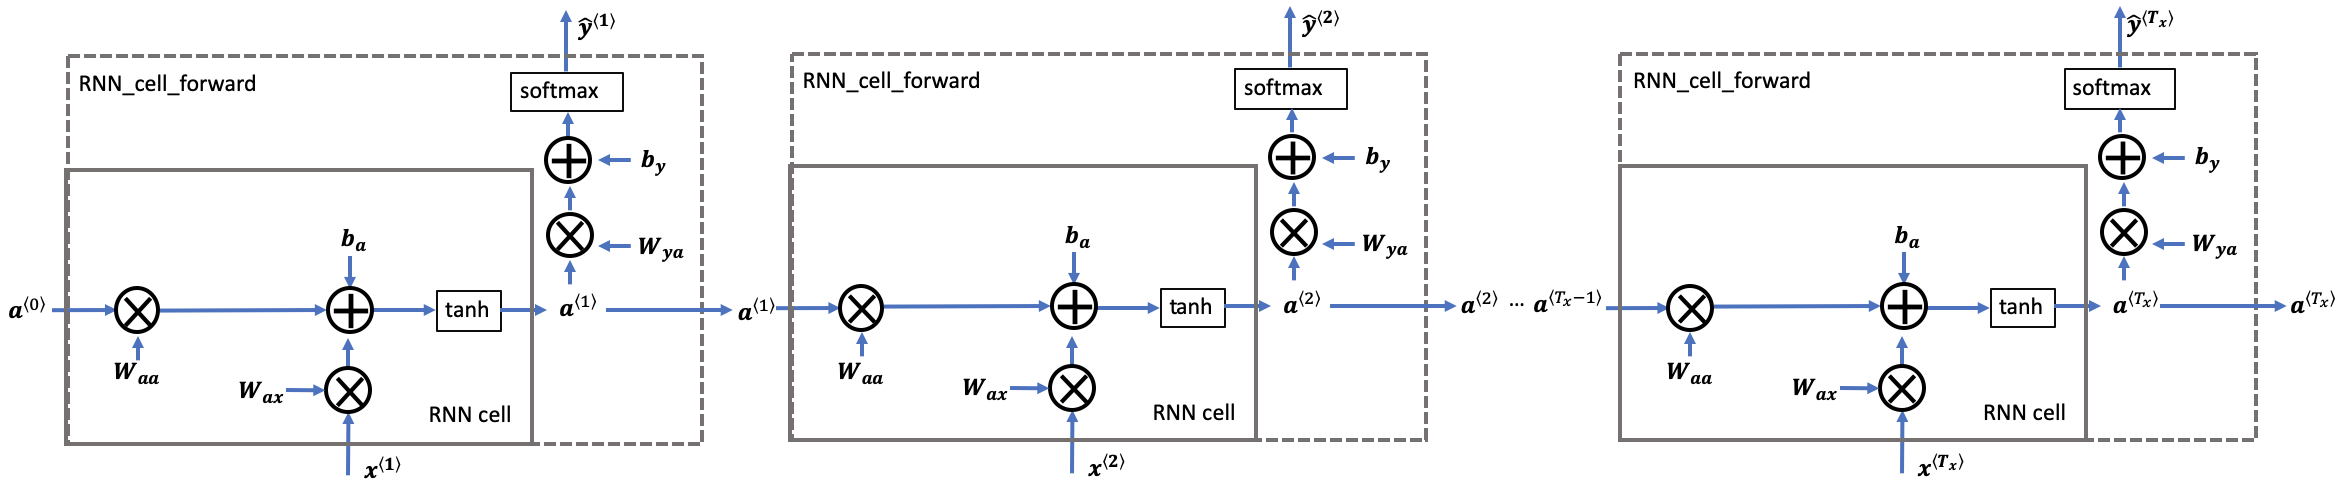
<caption><center> **Figure 3**: Basic RNN. The input sequence $x = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$  is carried over $T_x$ time steps. The network outputs $y = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$. </center></caption>


**Exercise**: Code the forward propagation of the RNN described in Figure (3).

**Instructions**:
* Create a 3D array of zeros, $a$ of shape $(n_{a}, m, T_{x})$ that will store all the hidden states computed by the RNN.
* Create a 3D array of zeros, $\hat{y}$, of shape $(n_{y}, m, T_{x})$ that will store the predictions.  
    - Note that in this case, $T_{y} = T_{x}$ (the prediction and input have the same number of time steps).
* Initialize the 2D hidden state `a_next` by setting it equal to the initial hidden state, $a_{0}$.
* At each time step $t$:
    - Get $x^{\langle t \rangle}$, which is a 2D slice of $x$ for a single time step $t$.
        - $x^{\langle t \rangle}$ has shape $(n_{x}, m)$
        - $x$ has shape $(n_{x}, m, T_{x})$
    - Update the 2D hidden state $a^{\langle t \rangle}$ (variable name `a_next`), the prediction $\hat{y}^{\langle t \rangle}$ and the cache by running `rnn_cell_forward`.
        - $a^{\langle t \rangle}$ has shape $(n_{a}, m)$
    - Store the 2D hidden state in the 3D tensor $a$, at the $t^{th}$ position.
        - $a$ has shape $(n_{a}, m, T_{x})$
    - Store the 2D $\hat{y}^{\langle t \rangle}$ prediction (variable name `yt_pred`) in the 3D tensor $\hat{y}_{pred}$ at the $t^{th}$ position.
        - $\hat{y}^{\langle t \rangle}$ has shape $(n_{y}, m)$
        - $\hat{y}$ has shape $(n_{y}, m, T_x)$
    - Append the cache to the list of caches.
* Return the 3D tensor $a$ and $\hat{y}$, as well as the list of caches.

#### Additional Hints
- [np.zeros](https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html)
- If you have a 3 dimensional numpy array and are indexing by its third dimension, you can use array slicing like this: `var_name[:,:,i]`.

In [7]:
# GRADED FUNCTION: rnn_forward

def rnn_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network described in Figure (3).

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y_pred -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of caches, x)
    """
    
    # Initialize "caches" which will contain the list of all caches
    caches = []
    
    # Retrieve dimensions from shapes of x and parameters["Wya"]
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wya"].shape
    
    ### START CODE HERE ###
    
    # initialize "a" and "y" with zeros (≈2 lines)
    a = np.zeros((n_a,m,T_x))
    y_pred = np.zeros((n_y,m,T_x))
    
    # Initialize a_next (≈1 line)
    a_next = a0
    
    # loop over all time-steps
    for t in range(T_x):
      a_next, yt_pred, cache = rnn_cell_forward(x[:,:,t], a_next, parameters)
      a[:,:,t] = a_next
      y_pred[:,:,t] = yt_pred
      caches.append(cache)

    ### END CODE HERE ###
    
    # store values needed for backward propagation in cache
    caches = (caches, x)
    
    return a, y_pred, caches

In [8]:
np.random.seed(1)
x_tmp = np.random.randn(3,10,4)
a0_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Waa'] = np.random.randn(5,5)
parameters_tmp['Wax'] = np.random.randn(5,3)
parameters_tmp['Wya'] = np.random.randn(2,5)
parameters_tmp['ba'] = np.random.randn(5,1)
parameters_tmp['by'] = np.random.randn(2,1)

a_tmp, y_pred_tmp, caches_tmp = rnn_forward(x_tmp, a0_tmp, parameters_tmp)
print("a[4][1] = \n", a_tmp[4][1])
print("a.shape = \n", a_tmp.shape)
print("y_pred[1][3] =\n", y_pred_tmp[1][3])
print("y_pred.shape = \n", y_pred_tmp.shape)
print("caches[1][1][3] =\n", caches_tmp[1][1][3])
print("len(caches) = \n", len(caches_tmp))

a[4][1] = 
 [-0.99999375  0.77911235 -0.99861469 -0.99833267]
a.shape = 
 (5, 10, 4)
y_pred[1][3] =
 [0.79560373 0.86224861 0.11118257 0.81515947]
y_pred.shape = 
 (2, 10, 4)
caches[1][1][3] =
 [-1.1425182  -0.34934272 -0.20889423  0.58662319]
len(caches) = 
 2


**Expected Output**:

```Python
a[4][1] = 
 [-0.99999375  0.77911235 -0.99861469 -0.99833267]
a.shape = 
 (5, 10, 4)
y_pred[1][3] =
 [ 0.79560373  0.86224861  0.11118257  0.81515947]
y_pred.shape = 
 (2, 10, 4)
caches[1][1][3] =
 [-1.1425182  -0.34934272 -0.20889423  0.58662319]
len(caches) = 
 2
```

Congratulations! You've successfully built the forward propagation of a recurrent neural network from scratch. 

#### Situations when this RNN will perform better:
- This will work well enough for some applications, but it suffers from the vanishing gradient problems. 
- The RNN works best when each output $\hat{y}^{\langle t \rangle}$ can be estimated using "local" context.  
- "Local" context refers to information that is close to the prediction's time step $t$.
- More formally, local context refers to inputs $x^{\langle t' \rangle}$ and predictions $\hat{y}^{\langle t \rangle}$ where $t'$ is close to $t$.

In the next part, you will build a more complex LSTM model, which is better at addressing vanishing gradients. The LSTM will be better able to remember a piece of information and keep it saved for many timesteps. 

## 2 - Long Short-Term Memory (LSTM) network

The following figure shows the operations of an LSTM-cell.

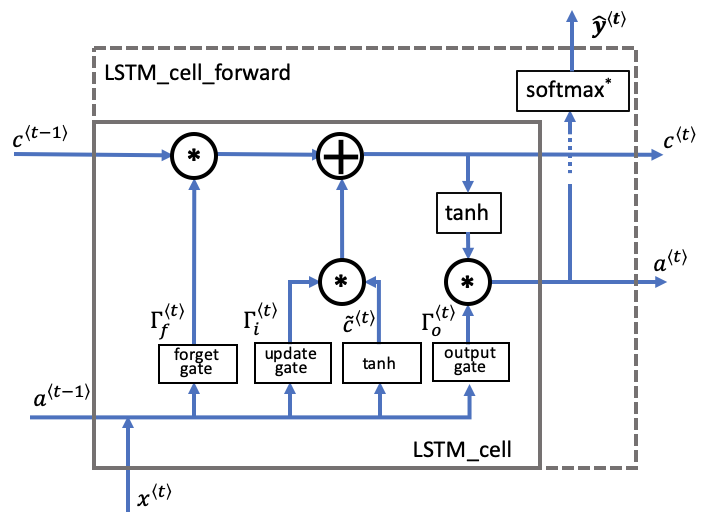
<caption><center> **Figure 4**: LSTM-cell. This tracks and updates a "cell state" or memory variable $c^{\langle t \rangle}$ at every time-step, which can be different from $a^{\langle t \rangle}$. </center></caption>

Similar to the RNN example above, you will start by implementing the LSTM cell for a single time-step. Then you can iteratively call it from inside a "for-loop" to have it process an input with $T_x$ time-steps. 

### Overview of gates and states

#### - Forget gate $\mathbf{\Gamma}_{f}$

* Let's assume we are reading words in a piece of text, and plan to use an LSTM to keep track of grammatical structures, such as whether the subject is singular ("puppy") or plural ("puppies"). 
* If the subject changes its state (from a singular word to a plural word), the memory of the previous state becomes outdated, so we "forget" that outdated state.
* The "forget gate" is a tensor containing values that are between 0 and 1.
    * If a unit in the forget gate has a value close to 0, the LSTM will "forget" the stored state in the corresponding unit of the previous cell state.
    * If a unit in the forget gate has a value close to 1, the LSTM will mostly remember the corresponding value in the stored state.

##### Equation

$$\mathbf{\Gamma}_f^{\langle t \rangle} = \sigma(\mathbf{W}_f[\mathbf{a}^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_f)\tag{1} $$

##### Explanation of the equation:

* $\mathbf{W_{f}}$ contains weights that govern the forget gate's behavior. 
* The previous time step's hidden state $[a^{\langle t-1 \rangle}$ and current time step's input $x^{\langle t \rangle}]$ are concatenated together and multiplied by $\mathbf{W_{f}}$. 
* A sigmoid function is used to make each of the gate tensor's values $\mathbf{\Gamma}_f^{\langle t \rangle}$ range from 0 to 1.
* The forget gate  $\mathbf{\Gamma}_f^{\langle t \rangle}$ has the same dimensions as the previous cell state $c^{\langle t-1 \rangle}$. 
* This means that the two can be multiplied together, element-wise.
* Multiplying the tensors $\mathbf{\Gamma}_f^{\langle t \rangle} * \mathbf{c}^{\langle t-1 \rangle}$ is like applying a mask over the previous cell state.
* If a single value in $\mathbf{\Gamma}_f^{\langle t \rangle}$ is 0 or close to 0, then the product is close to 0.
    * This keeps the information stored in the corresponding unit in $\mathbf{c}^{\langle t-1 \rangle}$ from being remembered for the next time step.
* Similarly, if one value is close to 1, the product is close to the original value in the previous cell state.
    * The LSTM will keep the information from the corresponding unit of $\mathbf{c}^{\langle t-1 \rangle}$, to be used in the next time step.
    
##### Variable names in the code
The variable names in the code are similar to the equations, with slight differences.  
* `Wf`: forget gate weight $\mathbf{W}_{f}$
* `Wb`: forget gate bias $\mathbf{W}_{b}$
* `ft`: forget gate $\Gamma_f^{\langle t \rangle}$

#### Candidate value $\tilde{\mathbf{c}}^{\langle t \rangle}$
* The candidate value is a tensor containing information from the current time step that **may** be stored in the current cell state $\mathbf{c}^{\langle t \rangle}$.
* Which parts of the candidate value get passed on depends on the update gate.
* The candidate value is a tensor containing values that range from -1 to 1.
* The tilde "~" is used to differentiate the candidate $\tilde{\mathbf{c}}^{\langle t \rangle}$ from the cell state $\mathbf{c}^{\langle t \rangle}$.

##### Equation
$$\mathbf{\tilde{c}}^{\langle t \rangle} = \tanh\left( \mathbf{W}_{c} [\mathbf{a}^{\langle t - 1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_{c} \right) \tag{3}$$

##### Explanation of the equation
* The 'tanh' function produces values between -1 and +1.


##### Variable names in the code
* `cct`: candidate value $\mathbf{\tilde{c}}^{\langle t \rangle}$

#### - Update gate $\mathbf{\Gamma}_{i}$

* We use the update gate to decide what aspects of the candidate $\tilde{\mathbf{c}}^{\langle t \rangle}$ to add to the cell state $c^{\langle t \rangle}$.
* The update gate decides what parts of a "candidate" tensor $\tilde{\mathbf{c}}^{\langle t \rangle}$ are passed onto the cell state $\mathbf{c}^{\langle t \rangle}$.
* The update gate is a tensor containing values between 0 and 1.
    * When a unit in the update gate is close to 1, it allows the value of the candidate $\tilde{\mathbf{c}}^{\langle t \rangle}$ to be passed onto the hidden state $\mathbf{c}^{\langle t \rangle}$
    * When a unit in the update gate is close to 0, it prevents the corresponding value in the candidate from being passed onto the hidden state.
* Notice that we use the subscript "i" and not "u", to follow the convention used in the literature.

##### Equation

$$\mathbf{\Gamma}_i^{\langle t \rangle} = \sigma(\mathbf{W}_i[a^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_i)\tag{2} $$ 

##### Explanation of the equation

* Similar to the forget gate, here $\mathbf{\Gamma}_i^{\langle t \rangle}$, the sigmoid produces values between 0 and 1.
* The update gate is multiplied element-wise with the candidate, and this product ($\mathbf{\Gamma}_{i}^{\langle t \rangle} * \tilde{c}^{\langle t \rangle}$) is used in determining the cell state $\mathbf{c}^{\langle t \rangle}$.

##### Variable names in code (Please note that they're different than the equations)
In the code, we'll use the variable names found in the academic literature.  These variables don't use "u" to denote "update".
* `Wi` is the update gate weight $\mathbf{W}_i$ (not "Wu") 
* `bi` is the update gate bias $\mathbf{b}_i$ (not "bu")
* `it` is the forget gate $\mathbf{\Gamma}_i^{\langle t \rangle}$ (not "ut")

#### - Cell state $\mathbf{c}^{\langle t \rangle}$

* The cell state is the "memory" that gets passed onto future time steps.
* The new cell state $\mathbf{c}^{\langle t \rangle}$ is a combination of the previous cell state and the candidate value.

##### Equation

$$ \mathbf{c}^{\langle t \rangle} = \mathbf{\Gamma}_f^{\langle t \rangle}* \mathbf{c}^{\langle t-1 \rangle} + \mathbf{\Gamma}_{i}^{\langle t \rangle} *\mathbf{\tilde{c}}^{\langle t \rangle} \tag{4} $$

##### Explanation of equation
* The previous cell state $\mathbf{c}^{\langle t-1 \rangle}$ is adjusted (weighted) by the forget gate $\mathbf{\Gamma}_{f}^{\langle t \rangle}$
* and the candidate value $\tilde{\mathbf{c}}^{\langle t \rangle}$, adjusted (weighted) by the update gate $\mathbf{\Gamma}_{i}^{\langle t \rangle}$

##### Variable names and shapes in the code
* `c`: cell state, including all time steps, $\mathbf{c}$ shape $(n_{a}, m, T)$
* `c_next`: new (next) cell state, $\mathbf{c}^{\langle t \rangle}$ shape $(n_{a}, m)$
* `c_prev`: previous cell state, $\mathbf{c}^{\langle t-1 \rangle}$, shape $(n_{a}, m)$

#### - Output gate $\mathbf{\Gamma}_{o}$

* The output gate decides what gets sent as the prediction (output) of the time step.
* The output gate is like the other gates. It contains values that range from 0 to 1.

##### Equation

$$ \mathbf{\Gamma}_o^{\langle t \rangle}=  \sigma(\mathbf{W}_o[\mathbf{a}^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_{o})\tag{5}$$ 

##### Explanation of the equation
* The output gate is determined by the previous hidden state $\mathbf{a}^{\langle t-1 \rangle}$ and the current input $\mathbf{x}^{\langle t \rangle}$
* The sigmoid makes the gate range from 0 to 1.


##### Variable names in the code
* `Wo`: output gate weight, $\mathbf{W_o}$
* `bo`: output gate bias, $\mathbf{b_o}$
* `ot`: output gate, $\mathbf{\Gamma}_{o}^{\langle t \rangle}$

#### - Hidden state $\mathbf{a}^{\langle t \rangle}$

* The hidden state gets passed to the LSTM cell's next time step.
* It is used to determine the three gates ($\mathbf{\Gamma}_{f}, \mathbf{\Gamma}_{u}, \mathbf{\Gamma}_{o}$) of the next time step.
* The hidden state is also used for the prediction $y^{\langle t \rangle}$.

##### Equation

$$ \mathbf{a}^{\langle t \rangle} = \mathbf{\Gamma}_o^{\langle t \rangle} * \tanh(\mathbf{c}^{\langle t \rangle})\tag{6} $$

##### Explanation of equation
* The hidden state $\mathbf{a}^{\langle t \rangle}$ is determined by the cell state $\mathbf{c}^{\langle t \rangle}$ in combination with the output gate $\mathbf{\Gamma}_{o}$.
* The cell state state is passed through the "tanh" function to rescale values between -1 and +1.
* The output gate acts like a "mask" that either preserves the values of $\tanh(\mathbf{c}^{\langle t \rangle})$ or keeps those values from being included in the hidden state $\mathbf{a}^{\langle t \rangle}$

##### Variable names  and shapes in the code
* `a`: hidden state, including time steps.  $\mathbf{a}$ has shape $(n_{a}, m, T_{x})$
* 'a_prev`: hidden state from previous time step. $\mathbf{a}^{\langle t-1 \rangle}$ has shape $(n_{a}, m)$
* `a_next`: hidden state for next time step.  $\mathbf{a}^{\langle t \rangle}$ has shape $(n_{a}, m)$ 

#### - Prediction $\mathbf{y}^{\langle t \rangle}_{pred}$
* The prediction in this use case is a classification, so we'll use a softmax.

The equation is:
$$\mathbf{y}^{\langle t \rangle}_{pred} = \textrm{softmax}(\mathbf{W}_{y} \mathbf{a}^{\langle t \rangle} + \mathbf{b}_{y})$$

##### Variable names and shapes in the code
* `y_pred`: prediction, including all time steps. $\mathbf{y}_{pred}$ has shape $(n_{y}, m, T_{x})$.  Note that $(T_{y} = T_{x})$ for this example.
* `yt_pred`: prediction for the current time step $t$. $\mathbf{y}^{\langle t \rangle}_{pred}$ has shape $(n_{y}, m)$

### 2.1 - LSTM cell

**Exercise**: Implement the LSTM cell described in the Figure (4).

**Instructions**:
1. Concatenate the hidden state $a^{\langle t-1 \rangle}$ and input $x^{\langle t \rangle}$ into a single matrix:  

$$concat = \begin{bmatrix} a^{\langle t-1 \rangle} \\ x^{\langle t \rangle} \end{bmatrix}$$  

2. Compute all the formulas 1 through 6 for the gates, hidden state, and cell state.
3. Compute the prediction $y^{\langle t \rangle}$.


#### Additional Hints
* You can use [numpy.concatenate](https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html).  Check which value to use for the `axis` parameter.
* The functions `sigmoid()` and `softmax` are imported from `rnn_utils.py`.
* [numpy.tanh](https://docs.scipy.org/doc/numpy/reference/generated/numpy.tanh.html)
* Use [np.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) for matrix multiplication.
* Notice that the variable names `Wi`, `bi` refer to the weights and biases of the **update** gate.  There are no variables named "Wu" or "bu" in this function.

In [11]:
# GRADED FUNCTION: lstm_cell_forward

def lstm_cell_forward(xt, a_prev, c_prev, parameters):
    """
    Implement a single forward step of the LSTM-cell as described in Figure (4)

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    c_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo --  Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
                        
    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    c_next -- next memory state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, c_next, a_prev, c_prev, xt, parameters)
    
    Note: ft/it/ot stand for the forget/update/output gates, cct stands for the candidate value (c tilde),
          c stands for the cell state (memory)
    """

    # Retrieve parameters from "parameters"
    Wf = parameters["Wf"] # forget gate weight
    bf = parameters["bf"]
    Wi = parameters["Wi"] # update gate weight (notice the variable name)
    bi = parameters["bi"] # (notice the variable name)
    Wc = parameters["Wc"] # candidate value weight
    bc = parameters["bc"]
    Wo = parameters["Wo"] # output gate weight
    bo = parameters["bo"]
    Wy = parameters["Wy"] # prediction weight
    by = parameters["by"]
    
    # Retrieve dimensions from shapes of xt and Wy
    n_x, m = xt.shape
    n_y, n_a = Wy.shape

    ### START CODE HERE ###
    # Concatenate a_prev and xt (≈3 lines)
    concat = np.zeros((n_a+n_x,m))
    concat[:n_a, :] = a_prev
    concat[n_a:, :] = xt

    # Compute values for ft, it, cct, c_next, ot, a_next using the formulas given figure (4) (≈6 lines)
    ft = sigmoid(np.dot(Wf,concat)+bf)
    it = sigmoid(np.dot(Wi,concat)+bi)
    ot = sigmoid(np.dot(Wo,concat)+bo)
    cct = np.tanh(np.dot(Wc,concat)+bc)
    c_next = it*cct + ft*c_prev
    a_next = ot * np.tanh(c_next)

    # Compute prediction of the LSTM cell (≈1 line)
    yt_pred = softmax(np.dot(Wy,a_next)+by)
    ### END CODE HERE ###

    # store values needed for backward propagation in cache
    cache = (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters)

    return a_next, c_next, yt_pred, cache

In [12]:
np.random.seed(1)
xt_tmp = np.random.randn(3,10)
a_prev_tmp = np.random.randn(5,10)
c_prev_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Wf'] = np.random.randn(5, 5+3)
parameters_tmp['bf'] = np.random.randn(5,1)
parameters_tmp['Wi'] = np.random.randn(5, 5+3)
parameters_tmp['bi'] = np.random.randn(5,1)
parameters_tmp['Wo'] = np.random.randn(5, 5+3)
parameters_tmp['bo'] = np.random.randn(5,1)
parameters_tmp['Wc'] = np.random.randn(5, 5+3)
parameters_tmp['bc'] = np.random.randn(5,1)
parameters_tmp['Wy'] = np.random.randn(2,5)
parameters_tmp['by'] = np.random.randn(2,1)

a_next_tmp, c_next_tmp, yt_tmp, cache_tmp = lstm_cell_forward(xt_tmp, a_prev_tmp, c_prev_tmp, parameters_tmp)
print("a_next[4] = \n", a_next_tmp[4])
print("a_next.shape = ", c_next_tmp.shape)
print("c_next[2] = \n", c_next_tmp[2])
print("c_next.shape = ", c_next_tmp.shape)
print("yt[1] =", yt_tmp[1])
print("yt.shape = ", yt_tmp.shape)
print("cache[1][3] =\n", cache_tmp[1][3])
print("len(cache) = ", len(cache_tmp))

a_next[4] = 
 [-0.66408471  0.0036921   0.02088357  0.22834167 -0.85575339  0.00138482
  0.76566531  0.34631421 -0.00215674  0.43827275]
a_next.shape =  (5, 10)
c_next[2] = 
 [ 0.63267805  1.00570849  0.35504474  0.20690913 -1.64566718  0.11832942
  0.76449811 -0.0981561  -0.74348425 -0.26810932]
c_next.shape =  (5, 10)
yt[1] = [0.79913913 0.15986619 0.22412122 0.15606108 0.97057211 0.31146381
 0.00943007 0.12666353 0.39380172 0.07828381]
yt.shape =  (2, 10)
cache[1][3] =
 [-0.16263996  1.03729328  0.72938082 -0.54101719  0.02752074 -0.30821874
  0.07651101 -1.03752894  1.41219977 -0.37647422]
len(cache) =  10


**Expected Output**:

```Python
a_next[4] = 
 [-0.66408471  0.0036921   0.02088357  0.22834167 -0.85575339  0.00138482
  0.76566531  0.34631421 -0.00215674  0.43827275]
a_next.shape =  (5, 10)
c_next[2] = 
 [ 0.63267805  1.00570849  0.35504474  0.20690913 -1.64566718  0.11832942
  0.76449811 -0.0981561  -0.74348425 -0.26810932]
c_next.shape =  (5, 10)
yt[1] = [ 0.79913913  0.15986619  0.22412122  0.15606108  0.97057211  0.31146381
  0.00943007  0.12666353  0.39380172  0.07828381]
yt.shape =  (2, 10)
cache[1][3] =
 [-0.16263996  1.03729328  0.72938082 -0.54101719  0.02752074 -0.30821874
  0.07651101 -1.03752894  1.41219977 -0.37647422]
len(cache) =  10
```

### 2.2 - Forward pass for LSTM

Now that you have implemented one step of an LSTM, you can now iterate this over this using a for-loop to process a sequence of $T_x$ inputs. 

<img src="images/LSTM_rnn.png" style="width:500;height:300px;">
<caption><center> **Figure 5**: LSTM over multiple time-steps. </center></caption>

**Exercise:** Implement `lstm_forward()` to run an LSTM over $T_x$ time-steps. 

**Instructions**
* Get the dimensions $n_x, n_a, n_y, m, T_x$ from the shape of the variables: `x` and `parameters`.
* Initialize the 3D tensors $a$, $c$ and $y$.
    - $a$: hidden state, shape $(n_{a}, m, T_{x})$
    - $c$: cell state, shape $(n_{a}, m, T_{x})$
    - $y$: prediction, shape $(n_{y}, m, T_{x})$ (Note that $T_{y} = T_{x}$ in this example).
    - **Note** Setting one variable equal to the other is a "copy by reference".  In other words, don't do `c = a', otherwise both these variables point to the same underlying variable.
* Initialize the 2D tensor $a^{\langle t \rangle}$ 
    - $a^{\langle t \rangle}$ stores the hidden state for time step $t$.  The variable name is `a_next`.
    - $a^{\langle 0 \rangle}$, the initial hidden state at time step 0, is passed in when calling the function. The variable name is `a0`.
    - $a^{\langle t \rangle}$ and $a^{\langle 0 \rangle}$ represent a single time step, so they both have the shape  $(n_{a}, m)$ 
    - Initialize $a^{\langle t \rangle}$ by setting it to the initial hidden state ($a^{\langle 0 \rangle}$) that is passed into the function.
* Initialize $c^{\langle t \rangle}$ with zeros. 
    - The variable name is `c_next`. 
    - $c^{\langle t \rangle}$ represents a single time step, so its shape is $(n_{a}, m)$
    - **Note**: create `c_next` as its own variable with its own location in memory.  Do not initialize it as a slice of the 3D tensor $c$.  In other words, **don't** do `c_next = c[:,:,0]`.
* For each time step, do the following:
    - From the 3D tensor $x$, get a 2D slice $x^{\langle t \rangle}$ at time step $t$.
    - Call the `lstm_cell_forward` function that you defined previously, to get the hidden state, cell state, prediction, and cache.
    - Store the hidden state, cell state and prediction (the 2D tensors) inside the 3D tensors.
    - Also append the cache to the list of caches.

In [ ]:
# GRADED FUNCTION: lstm_forward

def lstm_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network using an LSTM-cell described in Figure (4).

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc -- Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo -- Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
                        
    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    c -- The value of the cell state, numpy array of shape (n_a, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of all the caches, x)
    """

    # Initialize "caches", which will track the list of all the caches
    caches = []
    
    ### START CODE HERE ###
    Wy = parameters['Wy'] # saving parameters['Wy'] in a local variable in case students use Wy instead of parameters['Wy']
    # Retrieve dimensions from shapes of x and parameters['Wy'] (≈2 lines)
    n_x, m, T_x = x.shape
    n_y, n_a = Wy.shape
    
    # initialize "a", "c" and "y" with zeros (≈3 lines)
    a = np.zeros([n_a, m, T_x])
    c = np.zeros([n_a, m, T_x])
    y = np.zeros([n_y, m, T_x])
    
    # Initialize a_next and c_next (≈2 lines)
    a_next = a0
    c_next = np.zeros([n_a,m])
    
    # loop over all time-steps
    for t in range(T_x):
        # Update next hidden state, next memory state, compute the prediction, get the cache (≈1 line)
        a_next, c_next, yt, cache = lstm_cell_forward(x[:,:,t], a_next, c_next, parameters)
        # Save the value of the new "next" hidden state in a (≈1 line)
        a[:,:,t] = a_next
        # Save the value of the prediction in y (≈1 line)
        y[:,:,t] = yt
        # Save the value of the next cell state (≈1 line)
        c[:,:,t]  = c_next
        # Append the cache into caches (≈1 line)
        caches.append(cache)
        
    ### END CODE HERE ###
    
    # store values needed for backward propagation in cache
    caches = (caches, x)

    return a, y, c, caches

In [ ]:
np.random.seed(1)
x_tmp = np.random.randn(3,10,7)
a0_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Wf'] = np.random.randn(5, 5+3)
parameters_tmp['bf'] = np.random.randn(5,1)
parameters_tmp['Wi'] = np.random.randn(5, 5+3)
parameters_tmp['bi']= np.random.randn(5,1)
parameters_tmp['Wo'] = np.random.randn(5, 5+3)
parameters_tmp['bo'] = np.random.randn(5,1)
parameters_tmp['Wc'] = np.random.randn(5, 5+3)
parameters_tmp['bc'] = np.random.randn(5,1)
parameters_tmp['Wy'] = np.random.randn(2,5)
parameters_tmp['by'] = np.random.randn(2,1)

a_tmp, y_tmp, c_tmp, caches_tmp = lstm_forward(x_tmp, a0_tmp, parameters_tmp)
print("a[4][3][6] = ", a_tmp[4][3][6])
print("a.shape = ", a_tmp.shape)
print("y[1][4][3] =", y_tmp[1][4][3])
print("y.shape = ", y_tmp.shape)
print("caches[1][1][1] =\n", caches_tmp[1][1][1])
print("c[1][2][1]", c_tmp[1][2][1])
print("len(caches) = ", len(caches_tmp))

a[4][3][6] =  0.172117767533
a.shape =  (5, 10, 7)
y[1][4][3] = 0.95087346185
y.shape =  (2, 10, 7)
caches[1][1][1] =
 [ 0.82797464  0.23009474  0.76201118 -0.22232814 -0.20075807  0.18656139
  0.41005165]
c[1][2][1] -0.855544916718
len(caches) =  2


**Expected Output**:

```Python
a[4][3][6] =  0.172117767533
a.shape =  (5, 10, 7)
y[1][4][3] = 0.95087346185
y.shape =  (2, 10, 7)
caches[1][1][1] =
 [ 0.82797464  0.23009474  0.76201118 -0.22232814 -0.20075807  0.18656139
  0.41005165]
c[1][2][1] -0.855544916718
len(caches) =  2
```

Congratulations! You have now implemented the forward passes for the basic RNN and the LSTM. When using a deep learning framework, implementing the forward pass is sufficient to build systems that achieve great performance. 

The rest of this notebook is optional, and will not be graded.

## 3 - Backpropagation in recurrent neural networks (OPTIONAL / UNGRADED)

In modern deep learning frameworks, you only have to implement the forward pass, and the framework takes care of the backward pass, so most deep learning engineers do not need to bother with the details of the backward pass. If however you are an expert in calculus and want to see the details of backprop in RNNs, you can work through this optional portion of the notebook. 

When in an earlier course you implemented a simple (fully connected) neural network, you used backpropagation to compute the derivatives with respect to the cost to update the parameters. Similarly, in recurrent neural networks you can calculate the derivatives with respect to the cost in order to update the parameters. The backprop equations are quite complicated and we did not derive them in lecture. However, we will briefly present them below. 

### 3.1 - Basic RNN  backward pass

We will start by computing the backward pass for the basic RNN-cell.

<img src="images/rnn_cell_backprop.png" style="width:500;height:300px;"> <br>
<caption><center> **Figure 6**: RNN-cell's backward pass. Just like in a fully-connected neural network, the derivative of the cost function $J$ backpropagates through the RNN by following the chain-rule from calculus. The chain-rule is also used to calculate $(\frac{\partial J}{\partial W_{ax}},\frac{\partial J}{\partial W_{aa}},\frac{\partial J}{\partial b})$ to update the parameters $(W_{ax}, W_{aa}, b_a)$. </center></caption>

#### Deriving the one step backward functions: 

To compute the `rnn_cell_backward` you need to compute the following equations. It is a good exercise to derive them by hand. 

The derivative of $\tanh$ is $1-\tanh(x)^2$. You can find the complete proof [here](https://www.wyzant.com/resources/lessons/math/calculus/derivative_proofs/tanx). Note that: $ \text{sech}(x)^2 = 1 - \tanh(x)^2$

Similarly for $\frac{ \partial a^{\langle t \rangle} } {\partial W_{ax}}, \frac{ \partial a^{\langle t \rangle} } {\partial W_{aa}},  \frac{ \partial a^{\langle t \rangle} } {\partial b}$, the derivative of  $\tanh(u)$ is $(1-\tanh(u)^2)du$. 

The final two equations also follow the same rule and are derived using the $\tanh$ derivative. Note that the arrangement is done in a way to get the same dimensions to match.

In [ ]:
def rnn_cell_backward(da_next, cache):
    """
    Implements the backward pass for the RNN-cell (single time-step).

    Arguments:
    da_next -- Gradient of loss with respect to next hidden state
    cache -- python dictionary containing useful values (output of rnn_cell_forward())

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradients of input data, of shape (n_x, m)
                        da_prev -- Gradients of previous hidden state, of shape (n_a, m)
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dba -- Gradients of bias vector, of shape (n_a, 1)
    """
    
    # Retrieve values from cache
    (a_next, a_prev, xt, parameters) = cache
    
    # Retrieve values from parameters
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]

    ### START CODE HERE ###
    # compute the gradient of tanh with respect to a_next (≈1 line)
    dtanh = (1-a_next*a_next)*da_next

    # compute the gradient of the loss with respect to Wax (≈2 lines)
    dxt = np.dot(Wax.T,  dtanh)
    dWax = np.dot(dtanh,xt.T)

    # compute the gradient with respect to Waa (≈2 lines)
    da_prev = np.dot(Waa.T, dtanh)  
    dWaa = np.dot( dtanh,a_prev.T)

    # compute the gradient with respect to b (≈1 line)
    dba = np.sum( dtanh,keepdims=True,axis=-1)

    ### END CODE HERE ###
    
    # Store the gradients in a python dictionary
    gradients = {"dxt": dxt, "da_prev": da_prev, "dWax": dWax, "dWaa": dWaa, "dba": dba}
    
    return gradients

In [ ]:
np.random.seed(1)
xt_tmp = np.random.randn(3,10)
a_prev_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Wax'] = np.random.randn(5,3)
parameters_tmp['Waa'] = np.random.randn(5,5)
parameters_tmp['Wya'] = np.random.randn(2,5)
parameters_tmp['ba'] = np.random.randn(5,1)
parameters_tmp['by'] = np.random.randn(2,1)

a_next_tmp, yt_tmp, cache_tmp = rnn_cell_forward(xt_tmp, a_prev_tmp, parameters_tmp)

da_next_tmp = np.random.randn(5,10)
gradients_tmp = rnn_cell_backward(da_next_tmp, cache_tmp)
print("gradients[\"dxt\"][1][2] =", gradients_tmp["dxt"][1][2])
print("gradients[\"dxt\"].shape =", gradients_tmp["dxt"].shape)
print("gradients[\"da_prev\"][2][3] =", gradients_tmp["da_prev"][2][3])
print("gradients[\"da_prev\"].shape =", gradients_tmp["da_prev"].shape)
print("gradients[\"dWax\"][3][1] =", gradients_tmp["dWax"][3][1])
print("gradients[\"dWax\"].shape =", gradients_tmp["dWax"].shape)
print("gradients[\"dWaa\"][1][2] =", gradients_tmp["dWaa"][1][2])
print("gradients[\"dWaa\"].shape =", gradients_tmp["dWaa"].shape)
print("gradients[\"dba\"][4] =", gradients_tmp["dba"][4])
print("gradients[\"dba\"].shape =", gradients_tmp["dba"].shape)

gradients["dxt"][1][2] = -1.3872130506
gradients["dxt"].shape = (3, 10)
gradients["da_prev"][2][3] = -0.152399493774
gradients["da_prev"].shape = (5, 10)
gradients["dWax"][3][1] = 0.410772824935
gradients["dWax"].shape = (5, 3)
gradients["dWaa"][1][2] = 1.15034506685
gradients["dWaa"].shape = (5, 5)
gradients["dba"][4] = [ 0.20023491]
gradients["dba"].shape = (5, 1)


**Expected Output**:

<table>
    <tr>
        <td>
            **gradients["dxt"][1][2]** =
        </td>
        <td>
           -0.460564103059
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dxt"].shape** =
        </td>
        <td>
           (3, 10)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["da_prev"][2][3]** =
        </td>
        <td>
           0.0842968653807
        </td>
    </tr>
        <tr>
        <td>
            **gradients["da_prev"].shape** =
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWax"][3][1]** =
        </td>
        <td>
           0.393081873922
        </td>
    </tr>
            <tr>
        <td>
            **gradients["dWax"].shape** =
        </td>
        <td>
           (5, 3)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWaa"][1][2]** = 
        </td>
        <td>
           -0.28483955787
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWaa"].shape** =
        </td>
        <td>
           (5, 5)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dba"][4]** = 
        </td>
        <td>
           [ 0.80517166]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dba"].shape** = 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
</table>

#### Backward pass through the RNN

Computing the gradients of the cost with respect to $a^{\langle t \rangle}$ at every time-step $t$ is useful because it is what helps the gradient backpropagate to the previous RNN-cell. To do so, you need to iterate through all the time steps starting at the end, and at each step, you increment the overall $db_a$, $dW_{aa}$, $dW_{ax}$ and you store $dx$.

**Instructions**:

Implement the `rnn_backward` function. Initialize the return variables with zeros first and then loop through all the time steps while calling the `rnn_cell_backward` at each time timestep, update the other variables accordingly.

In [ ]:
def rnn_backward(da, caches):
    """
    Implement the backward pass for a RNN over an entire sequence of input data.

    Arguments:
    da -- Upstream gradients of all hidden states, of shape (n_a, m, T_x)
    caches -- tuple containing information from the forward pass (rnn_forward)
    
    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient w.r.t. the input data, numpy-array of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t the initial hidden state, numpy-array of shape (n_a, m)
                        dWax -- Gradient w.r.t the input's weight matrix, numpy-array of shape (n_a, n_x)
                        dWaa -- Gradient w.r.t the hidden state's weight matrix, numpy array of shape (n_a, n_a)
                        dba -- Gradient w.r.t the bias, of shape (n_a, 1)
    """
        
    ### START CODE HERE ###
    
    # Retrieve values from the first cache (t=1) of caches (≈2 lines)
    (caches, x) = caches
    (a1, a0, x1, parameters) = caches[0]
    
    # Retrieve dimensions from da's and x1's shapes (≈2 lines)
    n_a, m, T_x = da.shape
    n_x, m = x1.shape 
    
    # initialize the gradients with the right sizes (≈6 lines)
    dx = np.zeros((n_x, m, T_x)) 
    dWax = np.zeros((n_a, n_x))
    dWaa = np.zeros((n_a, n_a))
    dba = np.zeros((n_a, 1)) 
    da0 = np.zeros((n_a, m))
    da_prevt = np.zeros((n_a, m))  
    
    # Loop through all the time steps
    for t in reversed(range(T_x)):
        # Compute gradients at time step t. Choose wisely the "da_next" and the "cache" to use in the backward propagation step. (≈1 line)
        gradients = rnn_cell_backward(da[:, :, t] + da_prevt, caches[t])
        # Retrieve derivatives from gradients (≈ 1 line)
        dxt, da_prevt, dWaxt, dWaat, dbat = gradients["dxt"], gradients["da_prev"], gradients["dWax"], gradients["dWaa"], gradients["dba"]
        # Increment global derivatives w.r.t parameters by adding their derivative at time-step t (≈4 lines)
        dx[:, :, t] = dxt  
        dWax += dWaxt  
        dWaa += dWaat  
        dba += dbat  
        
    # Set da0 to the gradient of a which has been backpropagated through all time-steps (≈1 line) 
    da0 = da_prevt
    ### END CODE HERE ###

    # Store the gradients in a python dictionary
    gradients = {"dx": dx, "da0": da0, "dWax": dWax, "dWaa": dWaa,"dba": dba}
    
    return gradients

In [ ]:
np.random.seed(1)
x_tmp = np.random.randn(3,10,4)
a0_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Wax'] = np.random.randn(5,3)
parameters_tmp['Waa'] = np.random.randn(5,5)
parameters_tmp['Wya'] = np.random.randn(2,5)
parameters_tmp['ba'] = np.random.randn(5,1)
parameters_tmp['by'] = np.random.randn(2,1)

a_tmp, y_tmp, caches_tmp = rnn_forward(x_tmp, a0_tmp, parameters_tmp)
da_tmp = np.random.randn(5, 10, 4)
gradients_tmp = rnn_backward(da_tmp, caches_tmp)

print("gradients[\"dx\"][1][2] =", gradients_tmp["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients_tmp["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients_tmp["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients_tmp["da0"].shape)
print("gradients[\"dWax\"][3][1] =", gradients_tmp["dWax"][3][1])
print("gradients[\"dWax\"].shape =", gradients_tmp["dWax"].shape)
print("gradients[\"dWaa\"][1][2] =", gradients_tmp["dWaa"][1][2])
print("gradients[\"dWaa\"].shape =", gradients_tmp["dWaa"].shape)
print("gradients[\"dba\"][4] =", gradients_tmp["dba"][4])
print("gradients[\"dba\"].shape =", gradients_tmp["dba"].shape)

gradients["dx"][1][2] = [-2.07101689 -0.59255627  0.02466855  0.01483317]
gradients["dx"].shape = (3, 10, 4)
gradients["da0"][2][3] = -0.314942375127
gradients["da0"].shape = (5, 10)
gradients["dWax"][3][1] = 11.2641044965
gradients["dWax"].shape = (5, 3)
gradients["dWaa"][1][2] = 2.30333312658
gradients["dWaa"].shape = (5, 5)
gradients["dba"][4] = [-0.74747722]
gradients["dba"].shape = (5, 1)


**Expected Output**:

<table>
    <tr>
        <td>
            **gradients["dx"][1][2]** =
        </td>
        <td>
           [-2.07101689 -0.59255627  0.02466855  0.01483317]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dx"].shape** =
        </td>
        <td>
           (3, 10, 4)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["da0"][2][3]** =
        </td>
        <td>
           -0.314942375127
        </td>
    </tr>
        <tr>
        <td>
            **gradients["da0"].shape** =
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
         <tr>
        <td>
            **gradients["dWax"][3][1]** =
        </td>
        <td>
           11.2641044965
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWax"].shape** =
        </td>
        <td>
           (5, 3)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWaa"][1][2]** = 
        </td>
        <td>
           2.30333312658
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWaa"].shape** =
        </td>
        <td>
           (5, 5)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dba"][4]** = 
        </td>
        <td>
           [-0.74747722]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dba"].shape** = 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
</table>

## 3.2 - LSTM backward pass

### 3.2.1 One Step backward

The LSTM backward pass is slightly more complicated than the forward one. We have provided you with all the equations for the LSTM backward pass below. (If you enjoy calculus exercises feel free to try deriving these from scratch yourself.) 

### 3.2.2 gate derivatives

$$d \Gamma_o^{\langle t \rangle} = da_{next}*\tanh(c_{next}) * \Gamma_o^{\langle t \rangle}*(1-\Gamma_o^{\langle t \rangle})\tag{7}$$

$$d\tilde c^{\langle t \rangle} = dc_{next}*\Gamma_u^{\langle t \rangle}+ \Gamma_o^{\langle t \rangle} (1-\tanh(c_{next})^2) * i_t * da_{next} * \tilde c^{\langle t \rangle} * (1-\tanh(\tilde c)^2) \tag{8}$$

$$d\Gamma_u^{\langle t \rangle} = dc_{next}*\tilde c^{\langle t \rangle} + \Gamma_o^{\langle t \rangle} (1-\tanh(c_{next})^2) * \tilde c^{\langle t \rangle} * da_{next}*\Gamma_u^{\langle t \rangle}*(1-\Gamma_u^{\langle t \rangle})\tag{9}$$

$$d\Gamma_f^{\langle t \rangle} = dc_{next}*\tilde c_{prev} + \Gamma_o^{\langle t \rangle} (1-\tanh(c_{next})^2) * c_{prev} * da_{next}*\Gamma_f^{\langle t \rangle}*(1-\Gamma_f^{\langle t \rangle})\tag{10}$$

### 3.2.3 parameter derivatives 

$$ dW_f = d\Gamma_f^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{11} $$
$$ dW_u = d\Gamma_u^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{12} $$
$$ dW_c = d\tilde c^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{13} $$
$$ dW_o = d\Gamma_o^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{14}$$

To calculate $db_f, db_u, db_c, db_o$ you just need to sum across the horizontal (axis= 1) axis on $d\Gamma_f^{\langle t \rangle}, d\Gamma_u^{\langle t \rangle}, d\tilde c^{\langle t \rangle}, d\Gamma_o^{\langle t \rangle}$ respectively. Note that you should have the `keep_dims = True` option.

Finally, you will compute the derivative with respect to the previous hidden state, previous memory state, and input.

$$ da_{prev} = W_f^T*d\Gamma_f^{\langle t \rangle} + W_u^T * d\Gamma_u^{\langle t \rangle}+ W_c^T * d\tilde c^{\langle t \rangle} + W_o^T * d\Gamma_o^{\langle t \rangle} \tag{15}$$
Here, the weights for equations 13 are the first n_a, (i.e. $W_f = W_f[:n_a,:]$ etc...)

$$ dc_{prev} = dc_{next}\Gamma_f^{\langle t \rangle} + \Gamma_o^{\langle t \rangle} * (1- \tanh(c_{next})^2)*\Gamma_f^{\langle t \rangle}*da_{next} \tag{16}$$
$$ dx^{\langle t \rangle} = W_f^T*d\Gamma_f^{\langle t \rangle} + W_u^T * d\Gamma_u^{\langle t \rangle}+ W_c^T * d\tilde c_t + W_o^T * d\Gamma_o^{\langle t \rangle}\tag{17} $$
where the weights for equation 15 are from n_a to the end, (i.e. $W_f = W_f[n_a:,:]$ etc...)

**Exercise:** Implement `lstm_cell_backward` by implementing equations $7-17$ below. Good luck! :)

In [ ]:
def lstm_cell_backward(da_next, dc_next, cache):
    """
    Implement the backward pass for the LSTM-cell (single time-step).

    Arguments:
    da_next -- Gradients of next hidden state, of shape (n_a, m)
    dc_next -- Gradients of next cell state, of shape (n_a, m)
    cache -- cache storing information from the forward pass

    Returns:
    gradients -- python dictionary containing:
                        dxt -- Gradient of input data at time-step t, of shape (n_x, m)
                        da_prev -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dc_prev -- Gradient w.r.t. the previous memory state, of shape (n_a, m, T_x)
                        dWf -- Gradient w.r.t. the weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dWc -- Gradient w.r.t. the weight matrix of the memory gate, numpy array of shape (n_a, n_a + n_x)
                        dWo -- Gradient w.r.t. the weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
                        dbo -- Gradient w.r.t. biases of the output gate, of shape (n_a, 1)
    """

    # Retrieve information from "cache"
    (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters) = cache
    
    ### START CODE HERE ###
    # Retrieve dimensions from xt's and a_next's shape (≈2 lines)
    n_x, m = xt.shape 
    n_a, m = a_next.shape 
    
    # Compute gates related derivatives, you can find their values can be found by looking carefully at equations (7) to (10) (≈4 lines)
    # Code equations (7) to (10) (≈4 lines)
    dit = (da_next * ot * (1 - np.tanh(c_next) ** 2) + dc_next) * cct * (1 - it) * it
    dft = (da_next * ot * (1 - np.tanh(c_next) ** 2) + dc_next) * c_prev * ft * (1 - ft)
    dot = da_next * np.tanh(c_next) * ot * (1 - ot)
    dcct = (da_next * ot * (1 - np.tanh(c_next) ** 2) + dc_next) * it * (1 - cct ** 2)

    # Compute parameters related derivatives. Use equations (11)-(14) (≈8 lines)
    dWf = np.dot(dft,np.concatenate((a_prev, xt), axis=0).T) # or use np.dot(dft, np.hstack([a_prev.T, xt.T]))
    dWi = np.dot(dit,np.concatenate((a_prev, xt), axis=0).T)
    dWc = np.dot(dcct,np.concatenate((a_prev, xt), axis=0).T)
    dWo = np.dot(dot,np.concatenate((a_prev, xt), axis=0).T)
    dbf = np.sum(dft,axis=1,keepdims=True)
    dbi = np.sum(dit,axis=1,keepdims=True) 
    dbc = np.sum(dcct,axis=1,keepdims=True) 
    dbo = np.sum(dot,axis=1,keepdims=True)  

    # Compute derivatives w.r.t previous hidden state, previous memory state and input. Use equations (15)-(17). (≈3 lines)
    da_prev = np.dot(parameters['Wf'][:,:n_a].T,dft)+np.dot(parameters['Wi'][:,:n_a].T,dit)+np.dot(parameters['Wc'][:,:n_a].T,dcct)+np.dot(parameters['Wo'][:,:n_a].T,dot) 
    dc_prev = dc_next*ft+ot*(1-np.square(np.tanh(c_next)))*ft*da_next 
    dxt = np.dot(parameters['Wf'][:,n_a:].T,dft)+np.dot(parameters['Wi'][:,n_a:].T,dit)+np.dot(parameters['Wc'][:,n_a:].T,dcct)+np.dot(parameters['Wo'][:,n_a:].T,dot) 
    ### END CODE HERE ###
    
    # Save gradients in dictionary
    gradients = {"dxt": dxt, "da_prev": da_prev, "dc_prev": dc_prev, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}

    return gradients

In [ ]:
np.random.seed(1)
xt_tmp = np.random.randn(3,10)
a_prev_tmp = np.random.randn(5,10)
c_prev_tmp = np.random.randn(5,10)
parameters_tmp = {}
parameters_tmp['Wf'] = np.random.randn(5, 5+3)
parameters_tmp['bf'] = np.random.randn(5,1)
parameters_tmp['Wi'] = np.random.randn(5, 5+3)
parameters_tmp['bi'] = np.random.randn(5,1)
parameters_tmp['Wo'] = np.random.randn(5, 5+3)
parameters_tmp['bo'] = np.random.randn(5,1)
parameters_tmp['Wc'] = np.random.randn(5, 5+3)
parameters_tmp['bc'] = np.random.randn(5,1)
parameters_tmp['Wy'] = np.random.randn(2,5)
parameters_tmp['by'] = np.random.randn(2,1)

a_next_tmp, c_next_tmp, yt_tmp, cache_tmp = lstm_cell_forward(xt_tmp, a_prev_tmp, c_prev_tmp, parameters_tmp)

da_next_tmp = np.random.randn(5,10)
dc_next_tmp = np.random.randn(5,10)
gradients_tmp = lstm_cell_backward(da_next_tmp, dc_next_tmp, cache_tmp)
print("gradients[\"dxt\"][1][2] =", gradients_tmp["dxt"][1][2])
print("gradients[\"dxt\"].shape =", gradients_tmp["dxt"].shape)
print("gradients[\"da_prev\"][2][3] =", gradients_tmp["da_prev"][2][3])
print("gradients[\"da_prev\"].shape =", gradients_tmp["da_prev"].shape)
print("gradients[\"dc_prev\"][2][3] =", gradients_tmp["dc_prev"][2][3])
print("gradients[\"dc_prev\"].shape =", gradients_tmp["dc_prev"].shape)
print("gradients[\"dWf\"][3][1] =", gradients_tmp["dWf"][3][1])
print("gradients[\"dWf\"].shape =", gradients_tmp["dWf"].shape)
print("gradients[\"dWi\"][1][2] =", gradients_tmp["dWi"][1][2])
print("gradients[\"dWi\"].shape =", gradients_tmp["dWi"].shape)
print("gradients[\"dWc\"][3][1] =", gradients_tmp["dWc"][3][1])
print("gradients[\"dWc\"].shape =", gradients_tmp["dWc"].shape)
print("gradients[\"dWo\"][1][2] =", gradients_tmp["dWo"][1][2])
print("gradients[\"dWo\"].shape =", gradients_tmp["dWo"].shape)
print("gradients[\"dbf\"][4] =", gradients_tmp["dbf"][4])
print("gradients[\"dbf\"].shape =", gradients_tmp["dbf"].shape)
print("gradients[\"dbi\"][4] =", gradients_tmp["dbi"][4])
print("gradients[\"dbi\"].shape =", gradients_tmp["dbi"].shape)
print("gradients[\"dbc\"][4] =", gradients_tmp["dbc"][4])
print("gradients[\"dbc\"].shape =", gradients_tmp["dbc"].shape)
print("gradients[\"dbo\"][4] =", gradients_tmp["dbo"][4])
print("gradients[\"dbo\"].shape =", gradients_tmp["dbo"].shape)

gradients["dxt"][1][2] = 3.23055911511
gradients["dxt"].shape = (3, 10)
gradients["da_prev"][2][3] = -0.0639621419711
gradients["da_prev"].shape = (5, 10)
gradients["dc_prev"][2][3] = 0.797522038797
gradients["dc_prev"].shape = (5, 10)
gradients["dWf"][3][1] = -0.147954838164
gradients["dWf"].shape = (5, 8)
gradients["dWi"][1][2] = 1.05749805523
gradients["dWi"].shape = (5, 8)
gradients["dWc"][3][1] = 2.30456216369
gradients["dWc"].shape = (5, 8)
gradients["dWo"][1][2] = 0.331311595289
gradients["dWo"].shape = (5, 8)
gradients["dbf"][4] = [ 0.18864637]
gradients["dbf"].shape = (5, 1)
gradients["dbi"][4] = [-0.40142491]
gradients["dbi"].shape = (5, 1)
gradients["dbc"][4] = [ 0.25587763]
gradients["dbc"].shape = (5, 1)
gradients["dbo"][4] = [ 0.13893342]
gradients["dbo"].shape = (5, 1)


**Expected Output**:

<table>
    <tr>
        <td>
            **gradients["dxt"][1][2]** =
        </td>
        <td>
           3.23055911511
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dxt"].shape** =
        </td>
        <td>
           (3, 10)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["da_prev"][2][3]** =
        </td>
        <td>
           -0.0639621419711
        </td>
    </tr>
        <tr>
        <td>
            **gradients["da_prev"].shape** =
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
         <tr>
        <td>
            **gradients["dc_prev"][2][3]** =
        </td>
        <td>
           0.797522038797
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dc_prev"].shape** =
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWf"][3][1]** = 
        </td>
        <td>
           -0.147954838164
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWf"].shape** =
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWi"][1][2]** = 
        </td>
        <td>
           1.05749805523
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWi"].shape** = 
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            **gradients["dWc"][3][1]** = 
        </td>
        <td>
           2.30456216369
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWc"].shape** = 
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            **gradients["dWo"][1][2]** = 
        </td>
        <td>
           0.331311595289
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWo"].shape** = 
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            **gradients["dbf"][4]** = 
        </td>
        <td>
           [ 0.18864637]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbf"].shape** = 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
    <tr>
        <td>
            **gradients["dbi"][4]** = 
        </td>
        <td>
           [-0.40142491]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbi"].shape** = 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbc"][4]** = 
        </td>
        <td>
           [ 0.25587763]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbc"].shape** = 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbo"][4]** = 
        </td>
        <td>
           [ 0.13893342]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbo"].shape** = 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
</table>

### 3.3 Backward pass through the LSTM RNN

This part is very similar to the `rnn_backward` function you implemented above. You will first create variables of the same dimension as your return variables. You will then iterate over all the time steps starting from the end and call the one step function you implemented for LSTM at each iteration. You will then update the parameters by summing them individually. Finally return a dictionary with the new gradients. 

**Instructions**: Implement the `lstm_backward` function. Create a for loop starting from $T_x$ and going backward. For each step call `lstm_cell_backward` and update the your old gradients by adding the new gradients to them. Note that `dxt` is not updated but is stored.

In [ ]:
def lstm_backward(da, caches):
    
    """
    Implement the backward pass for the RNN with LSTM-cell (over a whole sequence).

    Arguments:
    da -- Gradients w.r.t the hidden states, numpy-array of shape (n_a, m, T_x)
    caches -- cache storing information from the forward pass (lstm_forward)

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient of inputs, of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dWf -- Gradient w.r.t. the weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dWc -- Gradient w.r.t. the weight matrix of the memory gate, numpy array of shape (n_a, n_a + n_x)
                        dWo -- Gradient w.r.t. the weight matrix of the save gate, numpy array of shape (n_a, n_a + n_x)
                        dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
                        dbo -- Gradient w.r.t. biases of the save gate, of shape (n_a, 1)
    """

    # Retrieve values from the first cache (t=1) of caches.
    (caches, x) = caches
    (a1, c1, a0, c0, f1, i1, cc1, o1, x1, parameters) = caches[0]
    
    ### START CODE HERE ###
    # Retrieve dimensions from da's and x1's shapes (≈2 lines)
    n_a, m, T_x = da.shape
    n_x, m = x1.shape
    
    # initialize the gradients with the right sizes (≈12 lines)
    dx = np.zeros((n_x, m, T_x))
    da0 = np.zeros((n_a, m))
    da_prevt = np.zeros((n_a, m))
    dc_prevt = np.zeros((n_a, m))
    dWf = np.zeros((n_a, n_a + n_x))
    dWi = np.zeros((n_a, n_a + n_x))
    dWc = np.zeros((n_a, n_a + n_x))
    dWo = np.zeros((n_a, n_a + n_x))
    dbf = np.zeros((n_a, 1))
    dbi = np.zeros((n_a, 1))
    dbc = np.zeros((n_a, 1))
    dbo = np.zeros((n_a, 1))
    
    # loop back over the whole sequence
    for t in reversed(range(T_x)):
        # Compute all gradients using lstm_cell_backward
        gradients = lstm_cell_backward(da[:,:,t] + da_prevt, dc_prevt, caches[t])
        # Store or add the gradient to the parameters' previous step's gradient
        dx[:,:,t] = gradients["dxt"]
        dWf += gradients["dWf"]
        dWi += gradients["dWi"]
        dWc += gradients["dWc"]
        dWo += gradients["dWo"]
        dbf += gradients["dbf"]
        dbi += gradients["dbi"]
        dbc += gradients["dbc"]
        dbo += gradients["dbo"]
    # Set the first activation's gradient to the backpropagated gradient da_prev.
    da0 = gradients["da_prev"]
    
    ### END CODE HERE ###

    # Store the gradients in a python dictionary
    gradients = {"dx": dx, "da0": da0, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}
    
    return gradients

In [ ]:
np.random.seed(1)
x_tmp = np.random.randn(3,10,7)
a0_tmp = np.random.randn(5,10)

parameters_tmp = {}
parameters_tmp['Wf'] = np.random.randn(5, 5+3)
parameters_tmp['bf'] = np.random.randn(5,1)
parameters_tmp['Wi'] = np.random.randn(5, 5+3)
parameters_tmp['bi'] = np.random.randn(5,1)
parameters_tmp['Wo'] = np.random.randn(5, 5+3)
parameters_tmp['bo'] = np.random.randn(5,1)
parameters_tmp['Wc'] = np.random.randn(5, 5+3)
parameters_tmp['bc'] = np.random.randn(5,1)
parameters_tmp['Wy'] = np.random.randn(2,5)
parameters_tmp['by'] = np.random.randn(2,1)

a_tmp, y_tmp, c_tmp, caches_tmp = lstm_forward(x_tmp, a0_tmp, parameters_tmp)

da_tmp = np.random.randn(5, 10, 4)
gradients_tmp = lstm_backward(da_tmp, caches_tmp)

print("gradients[\"dx\"][1][2] =", gradients_tmp["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients_tmp["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients_tmp["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients_tmp["da0"].shape)
print("gradients[\"dWf\"][3][1] =", gradients_tmp["dWf"][3][1])
print("gradients[\"dWf\"].shape =", gradients_tmp["dWf"].shape)
print("gradients[\"dWi\"][1][2] =", gradients_tmp["dWi"][1][2])
print("gradients[\"dWi\"].shape =", gradients_tmp["dWi"].shape)
print("gradients[\"dWc\"][3][1] =", gradients_tmp["dWc"][3][1])
print("gradients[\"dWc\"].shape =", gradients_tmp["dWc"].shape)
print("gradients[\"dWo\"][1][2] =", gradients_tmp["dWo"][1][2])
print("gradients[\"dWo\"].shape =", gradients_tmp["dWo"].shape)
print("gradients[\"dbf\"][4] =", gradients_tmp["dbf"][4])
print("gradients[\"dbf\"].shape =", gradients_tmp["dbf"].shape)
print("gradients[\"dbi\"][4] =", gradients_tmp["dbi"][4])
print("gradients[\"dbi\"].shape =", gradients_tmp["dbi"].shape)
print("gradients[\"dbc\"][4] =", gradients_tmp["dbc"][4])
print("gradients[\"dbc\"].shape =", gradients_tmp["dbc"].shape)
print("gradients[\"dbo\"][4] =", gradients_tmp["dbo"][4])
print("gradients[\"dbo\"].shape =", gradients_tmp["dbo"].shape)

gradients["dx"][1][2] = [ 0.01980463 -0.02745056 -0.31327706  0.53886581]
gradients["dx"].shape = (3, 10, 4)
gradients["da0"][2][3] = -0.000284495289749
gradients["da0"].shape = (5, 10)
gradients["dWf"][3][1] = -0.0153890043327
gradients["dWf"].shape = (5, 8)
gradients["dWi"][1][2] = -0.10924217935
gradients["dWi"].shape = (5, 8)
gradients["dWc"][3][1] = 0.0793905844933
gradients["dWc"].shape = (5, 8)
gradients["dWo"][1][2] = -0.0810144543621
gradients["dWo"].shape = (5, 8)
gradients["dbf"][4] = [-0.24148921]
gradients["dbf"].shape = (5, 1)
gradients["dbi"][4] = [-0.08824333]
gradients["dbi"].shape = (5, 1)
gradients["dbc"][4] = [ 0.14411048]
gradients["dbc"].shape = (5, 1)
gradients["dbo"][4] = [-0.45977321]
gradients["dbo"].shape = (5, 1)


**Expected Output**:

<table>
    <tr>
        <td>
            **gradients["dx"][1][2]** =
        </td>
        <td>
           [-0.00173313  0.08287442 -0.30545663 -0.43281115]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dx"].shape** =
        </td>
        <td>
           (3, 10, 4)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["da0"][2][3]** =
        </td>
        <td>
           -0.095911501954
        </td>
    </tr>
        <tr>
        <td>
            **gradients["da0"].shape** =
        </td>
        <td>
           (5, 10)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWf"][3][1]** = 
        </td>
        <td>
           -0.0698198561274
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWf"].shape** =
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWi"][1][2]** = 
        </td>
        <td>
           0.102371820249
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWi"].shape** = 
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            **gradients["dWc"][3][1]** = 
        </td>
        <td>
           -0.0624983794927
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWc"].shape** = 
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            **gradients["dWo"][1][2]** = 
        </td>
        <td>
           0.0484389131444
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dWo"].shape** = 
        </td>
        <td>
           (5, 8)
        </td>
    </tr>
    <tr>
        <td>
            **gradients["dbf"][4]** = 
        </td>
        <td>
           [-0.0565788]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbf"].shape** = 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
    <tr>
        <td>
            **gradients["dbi"][4]** = 
        </td>
        <td>
           [-0.06997391]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbi"].shape** = 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbc"][4]** = 
        </td>
        <td>
           [-0.27441821]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbc"].shape** = 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbo"][4]** = 
        </td>
        <td>
           [ 0.16532821]
        </td>
    </tr>
        <tr>
        <td>
            **gradients["dbo"].shape** = 
        </td>
        <td>
           (5, 1)
        </td>
    </tr>
</table>

### Congratulations !

Congratulations on completing this assignment. You now understand how recurrent neural networks work! 

Let's go on to the next exercise, where you'll use an RNN to build a character-level language model.
